Load Python Libraries

In [2]:
Version: 0.5

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import datetime
%matplotlib inline

Import PV Data. PV Data's format is a single column, with each number representing the kWh output of each half-hour period. 

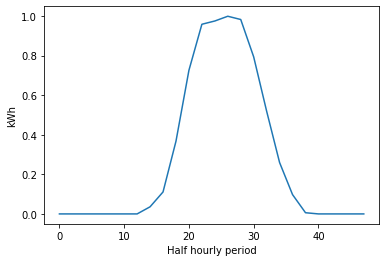

Annual Solar Generation: 3381.96 kWh


In [3]:
# import data
solar_profile = pd.read_csv("C:/Users/tangl/OneDrive/Engineering Course/Year 3/3YP/OXEMF/data/solar_example.csv", usecols=[1]).values

# plot data
plt.plot(solar_profile[4752:4800])  # just plotting a single day from the entire year
plt.ylabel("kWh")
plt.xlabel("Half hourly period")
plt.show()

# calculate annual generation
print("Annual Solar Generation: {:.2f} kWh".format(solar_profile.sum()))
 


Create Electrolyzer Class

In [4]:
class electrolyzer:
    def __init__(self,elec_price, production_rate,install_cost,max_power,min_power_percentage, water_price):
        self.elec_price = elec_price             #GBP Per MWh
        self.production_rate = production_rate   #kg of hydrogen produced per second per MW of electricity
        self.install_cost = install_cost         #in GBP
        self.max_power = max_power               #in MW
        self.min_power = max_power*min_power_percentage/100  #in MW, minimum power to retain its ability to ramp up and down quickly  
        self.water_price = water_price
        
    def getOpcost(self):
        total_costs = self.elec_price
        Opcost = total_costs*self.production_rate
        return Opcost

ITM HGas3SP Electrolyzer created below

In [13]:
itm_H3GSP = electrolyzer(160.3, 5/9, 2677440, 2,0.01,1)


Use a day as experimental sample

In [7]:
solar_profile = solar_profile[4752:4800]

Power = solar_profile*2*0.001                   #Average power(MW) of solar grid in the half hour period


Theoretical Electrolyzer Power Output in each half hour period <br>
(Taking into account max rate of change of power) <br>
(Without taking into account max and min power)

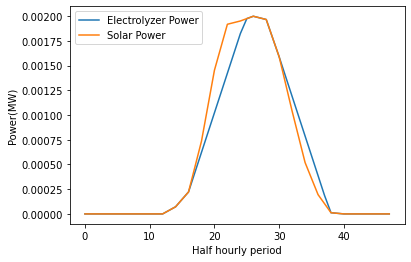

In [8]:
T = len(solar_profile)                   # no. of half hour periods
grid_demand = np.zeros((T,1))            # power required from grid 
H_produced = np.zeros((T,1))             # kg of hydrogen produced in the half-hour period


# solar power change compared to  previous half-hour period
p_change = np.zeros((T,1))               
for j in range(T):
    if j == 0: 
        p_change[j] = 0
    else: 
        p_change[j] = Power[j] - Power[j-1]

# for this test, we will set max power change of electrolyzer to be 2e-4 and 3e-5
max_p_change = 0.0002

needed_p_change = np.zeros((T,1))            # power change needed for electrolyzer
electrolyzer_power = np.zeros((T,1))

for j in range(T):
    if j == 0:
        electrolyzer_power[j] = Power[j]
        needed_p_change[j] = 0
    else: 
        needed_p_change[j] = Power[j] - electrolyzer_power[j-1]
    
    if abs(needed_p_change[j]) > max_p_change:      #if electrolyzer cannot handle power change
        electrolyzer_power[j] = electrolyzer_power[j-1] + np.sign(needed_p_change[j])*max_p_change
        
    elif abs(needed_p_change[j]) <= max_p_change:   #if electrolyzer can handle power change
        if electrolyzer_power[j-1] == Power[j-1]:      # if electrolyzer is handling it well
            electrolyzer_power[j] = Power[j]
        elif electrolyzer_power[j-1] != Power[j-1]:     # if electrolyzer was not in sync with solar power 
            electrolyzer_power[j] = electrolyzer_power[j-1] + np.sign(needed_p_change[j])*min(abs(max_p_change),abs(needed_p_change[j]))
            
ax = plt.subplot(1,1,1)
plt.plot(electrolyzer_power, label = 'Electrolyzer Power')
plt.plot(Power, label = 'Solar Power')
plt.xlabel('Half hourly period')
plt.ylabel('Power(MW)')

ax.legend()


Hydrogen produced in each half-hour period <br>
(Taking into account max and min power) <br>
Cost of electricity if electrolyzer takes electricity from grid <br>
Cost of water  <br>
CO2 emissions from grid electricity


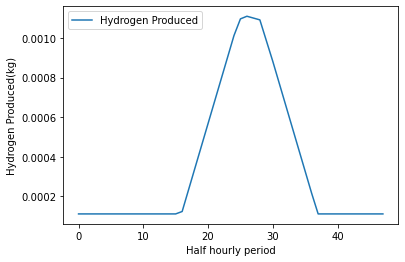

In [14]:
# electrolyzer takes electricity from grid, if solar power fadulls below min power 
# assume solar power is free 

# Records hydrogen produced in each half-hour period
for j in range(T):
    if electrolyzer_power[j] > itm_H3GSP.max_power:                      #if theoretical power exceeds max power
        H_produced[j] = itm_H3GSP.max_power*itm_H3GSP.production_rate 
    elif electrolyzer_power[j] >= itm_H3GSP.min_power:                          
        H_produced[j] = electrolyzer_power[j]*itm_H3GSP.production_rate 
    else:                                                               #if theoretical power is below min power
        H_produced[j] = itm_H3GSP.min_power*itm_H3GSP.production_rate
        grid_demand[j] = itm_H3GSP.min_power - electrolyzer_power[j] 
        
Total_elec_cost =sum(grid_demand*0.5*itm_H3GSP.elec_price)

Total_water_cost = sum(H_produced*itm_H3GSP.water_price) 

co2perelec = 0.1
co2_emissions = sum(grid_demand*co2perelec)

ax = plt.subplot(1,1,1)
plt.plot(H_produced, label = 'Hydrogen Produced')
plt.xlabel('Half hourly period')
plt.ylabel('Hydrogen Produced(kg)')

ax.legend()

Reverse Engineer actual electrolyzer power 

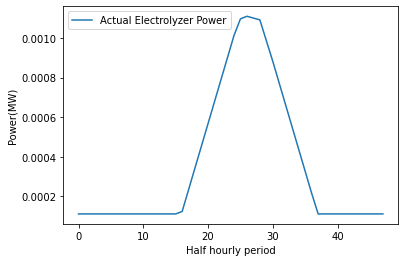

In [16]:
actual_electrolyzer_power = H_produced / itm_H3GSP.production_rate

ax = plt.subplot(1,1,1)
plt.plot(H_produced, label = 'Actual Electrolyzer Power')
plt.xlabel('Half hourly period')
plt.ylabel('Power(MW)')

ax.legend()

Code for Hydrogen Storage

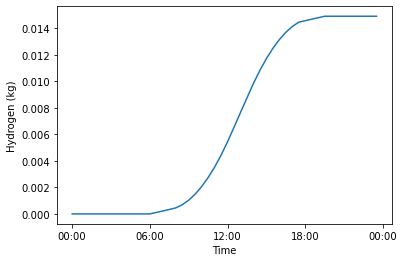

In [8]:
hydrogen_capacity = 10  # kg

T = len(solar_profile)                    # no. of half hour periods
outputi = np.zeros((T,1))  # hydrogen production flow
soc = np.zeros((T,1))  # weight of hydrogen stored


for j in range(T):
    if j == 0:
        socval = 0 
    else:
        socval = soc[j-1]                 #stores soc from the previous timeslot
    
    # if there is production of hydrogen
    if Power[j] > 0:      
        outputi[j] = H_produced[j]
        soc[j] = socval + outputi[j]     #battery is being discharged so soc decreases
        
    # if there is no production of hydrogen
    elif solar_profile[j] == 0: 
        soc[j] = socval                     # battery soc has no change

        
ax = plt.subplot(1,1,1)
p = plt.plot(soc)

plt.xticks([0,12,24,36,48])
ax.set_xticklabels(['00:00','06:00','12:00','18:00','00:00'])
plt.ylabel('Hydrogen (kg)', color='k')
plt.xlabel('Time', color='k')
plt.show()